In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

**IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers,optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as k
from sklearn.preprocessing import StandardScaler,normalize
import os
import glob
import random



In [ ]:
%cd /kaggle/input/lgg-mri-segmentation/kaggle_3m

In [ ]:
brain_df=pd.read_csv('/kaggle/input/data-csv/data_mask.csv')

In [ ]:
brain_df.info()

In [ ]:
brain_df.head()

In [ ]:
brain_df.isnull().sum()

In [ ]:
cv2.imread(brain_df.mask_path[623]).max()

In [ ]:
cv2.imread(brain_df.image_path[623]).min()

In [ ]:
brain_df.mask_path

In [ ]:
brain_df.image_path

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [ ]:
print(brain_df.columns)


In [ ]:

fig,axs=plt.subplots(6,2,figsize=(16,32))
count=0
for x in range(6):
    i=random.randint(0,len(brain_df))
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
    count += 1
fig.tight_layout()
    

In [ ]:
count=0
fig,axs=plt.subplots(12,3,figsize=(20,50))
for i in range(len(brain_df)):
    if brain_df['mask'][i] == 1 and count < 12:
        img=io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask=io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask,cmap='gray')

        img[mask == 255]= (255,0,0)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count += 1

fig.tight_layout()

In [ ]:
brain_df_train=brain_df.drop(columns=['patient_id'])
brain_df_train.shape

In [ ]:
brain_df_train['mask']=brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(brain_df_train,test_size=0.15)

In [ ]:
!pip install keras_preprocessing

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15)

In [ ]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='training',
    batch_size=16,
    shuffle=True,
    class_model='categorical',
    target_size=(256,256)
    
)
valid_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='validation',
    batch_size=16,
    shuffle=True,
    class_model='categorical',
    target_size=(256,256)
    
)

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    shuffle=False,
    class_model='categorical',
    target_size=(256,256)
    
)


In [ ]:
basemodel=ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))

In [ ]:
basemodel.summary()

In [ ]:
for layer in basemodel.layers:
    layers.trainable=False

In [ ]:
headmodel=basemodel.output
headmodel=AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel=Flatten(name="flatten")(headmodel)
headmodel=Dense(256,activation="relu")(headmodel)
headmodel=Dropout(0.3)(headmodel)
headmodel=Dense(256,activation="relu")(headmodel)
headmodel=Dropout(0.3)(headmodel)
headmodel=Dense(2,activation='softmax')(headmodel)
model=Model(inputs=basemodel.input,outputs=headmodel)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
earlystopping=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)
checkpointer=ModelCheckpoint(filepath='classifier-resnet-weights.keras',verbose=1,save_best_only=True)

In [ ]:
history=model.fit(train_generator,steps_per_epoch=train_generator.n//16,epochs=50,validation_data=valid_generator)

In [ ]:
model.save("/kaggle/working/Brain_Tumor_Model.h5")


In [ ]:
val_loss, val_acc = model.evaluate(train_generator, verbose=1)
print(f"Train Accuracy: {val_acc * 100:.2f}%")


In [ ]:
val_loss, val_acc = model.evaluate(valid_generator, verbose=1)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


In [ ]:
predict=[]
for i in test_predict:
    predict.append(str(np.argmax(i)))
predict=np.asarray(predict)

In [ ]:
predict

In [ ]:
original=np.asarray(test['mask'])[:len(predict)]
len(original)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(original,predict)
accuracy

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(original,predict)
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True)

In [ ]:
from sklearn.metrics import classification_report
report=classification_report(original,predict)
print(report)

In [2]:
from tensorflow.keras.models import load_model
model=load_model('/kaggle/input/brain-tumor-model/Brain_Tumor_Model.h5')

In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,751,428 (98.23 MB)

 Trainable params: 25,698,306 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Predicted Label: No Tumor with 99.36% confidence


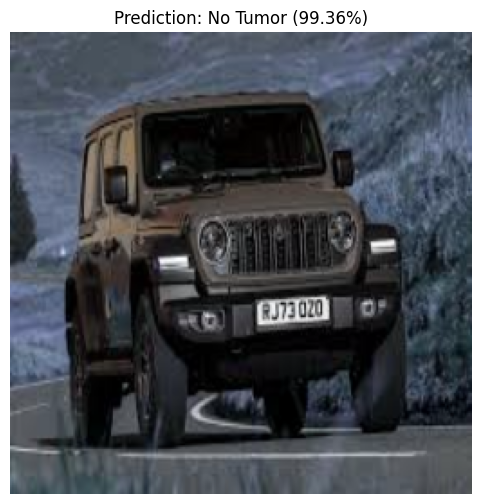

In [50]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['No Tumor', 'Tumor']

# Load the image
image_path = "/kaggle/input/randomimg/download (1).jpeg"
img = cv2.imread(image_path)

# Ensure the image is loaded correctly
if img is None:
    raise ValueError("Error: Image not found. Check the file path.")

# Resize the image to (256, 256)
img = cv2.resize(img, (256, 256))

# Convert grayscale to RGB if needed
if len(img.shape) == 2:  # If image is grayscale
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Normalize pixel values to [0,1] (important for model consistency)
img = img.astype("float32") / 255.0

# Expand dimensions to match model input shape (batch size of 1)
input_img = np.expand_dims(img, axis=0)  # Shape: (1, 256, 256, 3)

# Predict
pred = model.predict(input_img)[0]  # Extract prediction array
predicted_class = np.argmax(pred)  # Get the index of the highest probability
confidence = pred[predicted_class] * 100  # Convert to percentage

# Print the result
print(f"Predicted Label: {class_labels[predicted_class]} with {confidence:.2f}% confidence")

# Display the image with prediction and confidence score
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Prediction: {class_labels[predicted_class]} ({confidence:.2f}%)")
plt.axis("off")
plt.show()


In [1]:
import tensorflow as tf

# Load the .h5 model
h5_model_path = "/kaggle/input/brain-tumor-model/Brain_Tumor_Model.h5"  # Replace with your actual .h5 file path
model = tf.keras.models.load_model(h5_model_path)

# Convert to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite model
tflite_model_path = "Brain_Tumor_Model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("Model successfully converted and saved as model.tflite")


Saved artifact at '/tmp/tmpvhfiuhvp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140692778281520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778286448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778489408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778486592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778487120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778488704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778492576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778490640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778492224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778492048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140692778487824